###  Load and Clean EEG Data

In [1]:
import pandas as pd
import numpy as np

# Define file names
filenames = ['HR_01.txt', 'HR_02.txt', 'SL_01.txt', 'SL_02.txt', 'SK_01.txt', 'SK_02.txt']

# Function to load and clean data
def load_eeg_data(filename):
    # Skip the first few rows that contain metadata
    data = pd.read_csv(filename, delimiter=',', skiprows=4)  # Adjust skiprows based on actual file structure
    numeric_data = data.select_dtypes(include=[np.number])
    return numeric_data.to_numpy()

# Load and store data from all files
eeg_data = {name: load_eeg_data(name) for name in filenames}

# Print the shape of one dataset to verify
print(eeg_data['HR_01.txt'].shape)


(30355, 24)


### Preprocess Data (Filtering)

Apply a bandpass filter to isolate relevant frequency components.

In [2]:
from scipy.signal import butter, filtfilt

# Define bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data, axis=0)

# Set sampling rate and filter parameters
sampling_rate = 256  # Adjust based on actual sampling rate
lowcut = 0.5  # Hz
highcut = 50  # Hz

# Apply filter to all EEG data
filtered_eeg_data = {name: apply_bandpass_filter(data, lowcut, highcut, sampling_rate) for name, data in eeg_data.items()}

# Check shape of filtered data
print(filtered_eeg_data['HR_01.txt'].shape)


(30355, 24)


### Compute Power Spectrum

Calculate the power spectrum for each EEG channel using Welch's method.

In [3]:
from scipy.signal import welch

# Function to compute power spectrum
def compute_power_spectrum(data, fs):
    freqs, psd = welch(data, fs, nperseg=1024)
    return freqs, psd

# Compute power spectrum for each file and channel
power_spectrum_data = {}
for name, data in filtered_eeg_data.items():
    psd_list = []
    for channel in range(data.shape[1]):
        freqs, psd = compute_power_spectrum(data[:, channel], sampling_rate)
        psd_list.append(psd)
    power_spectrum_data[name] = np.array(psd_list)

# Print shape of power spectrum data
print(power_spectrum_data['HR_01.txt'].shape)


(24, 513)


### Extract Features from Power Spectrum

Extract features by computing the power in specific frequency bands.



In [4]:
# Define frequency bands
bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 50)}

# Function to calculate band power from power spectrum
def bandpower(psd, freqs, low, high):
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.sum(psd[idx_band])

# Extract features for each file
features = {}
for name, psd_list in power_spectrum_data.items():
    feature_matrix = []
    for psd in psd_list:
        feature_vector = [bandpower(psd, freqs, low, high) for low, high in bands.values()]
        feature_matrix.append(feature_vector)
    features[name] = np.array(feature_matrix)

# Check extracted features
print(features['HR_01.txt'].shape)


(24, 5)


####  Label Data
Assign labels based on the time intervals. 

In [5]:
# Define labels for each measurement
labels = {'HR_01.txt': 0, 'HR_02.txt': 1, 'SL_01.txt': 0, 'SL_02.txt': 1, 'SK_01.txt': 0, 'SK_02.txt': 1}

# Prepare features and labels for ML
X = np.concatenate([features[name] for name in filenames])
y = np.array([labels[name] for name in filenames for _ in range(features[name].shape[0])])

# Print feature and label shapes
print(X.shape, y.shape)


(144, 5) (144,)


###  Apply Machine Learning Model
Use a Random Forest classifier to predict stress levels.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Model accuracy: {accuracy * 100:.2f}%')
print('Classification Report:')
print(report)


Model accuracy: 61.36%
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.48      0.60        27
           1       0.50      0.82      0.62        17

    accuracy                           0.61        44
   macro avg       0.66      0.65      0.61        44
weighted avg       0.69      0.61      0.61        44



###  Evaluate and Compare
Compare the morning and evening data based on the extracted features and model predictions. 

In [9]:
# Convert bands.keys() to a list to access indices
band_names = list(bands.keys())

# Calculate average power in different bands for morning vs. evening
for band in band_names:
    band_index = band_names.index(band)  # Get the index of the band
    # Extract features for morning and evening
    morning_powers = [np.mean(features[name][:, band_index]) for name in ['HR_01.txt', 'SL_01.txt', 'SK_01.txt']]
    evening_powers = [np.mean(features[name][:, band_index]) for name in ['HR_02.txt', 'SL_02.txt', 'SK_02.txt']]
    
    print(f"{band.capitalize()} Band Power:")
    print(f"Morning: {np.mean(morning_powers)}")
    print(f"Evening: {np.mean(evening_powers)}")
    print()



Delta Band Power:
Morning: 2012715.6997404105
Evening: 21076910.88568538

Theta Band Power:
Morning: 4321.646891814911
Evening: 1159497.8463291188

Alpha Band Power:
Morning: 538.0386761764313
Evening: 290641.3292907902

Beta Band Power:
Morning: 905.1396747345757
Evening: 279661.58610555995

Gamma Band Power:
Morning: 100.83241052764345
Evening: 21198.874496196906



##### The results from your power spectrum analysis show the average power in different EEG frequency bands for morning and evening sessions. Here’s a detailed explanation of what these results might indicate:

### 1. Delta Band Power:
Morning: 2,012,715.70
Evening: 21,076,910.89

#### Explanation:

Delta Waves (0.5-4 Hz): These are the slowest brain waves, typically associated with deep sleep and restorative processes.
Higher Evening Power: The significantly higher power in the delta band during the evening might suggest that the subjects are experiencing a state of deeper relaxation or are potentially in a sleep-like state in the evening compared to the morning. It could also indicate increased restorative processes or fatigue accumulation over the day.
### 2. Theta Band Power:
Morning: 4,321.65
Evening: 1,159,497.85

#### Explanation:

Theta Waves (4-8 Hz): These waves are often linked with drowsiness, relaxation, and light sleep. They can also be associated with creative thinking and emotional processing.
Much Higher Evening Power: The evening power is significantly higher, which might reflect increased relaxation or cognitive processing in the evening. It may indicate a transition towards a more relaxed or introspective state as the day progresses.
### 3. Alpha Band Power:
Morning: 538.04
Evening: 290,641.33

### Explanation:

Alpha Waves (8-12 Hz): These are typically seen during relaxed, calm states when the eyes are closed but the person is awake. They are associated with relaxed alertness and mental coordination.
Much Higher Evening Power: The very high alpha power in the evening could signify a higher level of relaxation or a state of calmness in the evening compared to the morning. It may also indicate a greater level of relaxed wakefulness or mental peace in the evening.
### 4. Beta Band Power:
Morning: 905.14
Evening: 279,661.59

#### Explanation:

Beta Waves (12-30 Hz): These waves are associated with active thinking, problem-solving, and active concentration. Higher beta activity generally reflects cognitive engagement or stress.
Much Higher Evening Power: The higher beta power in the evening might suggest that subjects are more engaged in cognitive or stress-related activities in the evening. Alternatively, it could reflect increased mental activity or alertness later in the day.
### 5. Gamma Band Power:
Morning: 100.83
Evening: 21,198.87

#### Explanation:

Gamma Waves (30-50 Hz): These are the fastest brain waves, associated with high-level cognitive functions, sensory processing, and active information processing.
Much Higher Evening Power: The increase in gamma power in the evening might indicate heightened cognitive processing or increased mental effort in the evening. It could also reflect a state of high alertness or complex cognitive activities.


##### Summary
In general, the higher power in the evening across all frequency bands suggests that subjects might be experiencing increased cognitive processing or relaxation as the day progresses. It’s important to consider factors such as individual differences, daily routines, and overall mental state, as they can influence these measurements.

The results may imply that the evening data shows more pronounced changes in brain activity, potentially linked to the subjects' mental fatigue or stress levels. Further analysis, including statistical tests and comparisons, can provide more insights into these trends and their implications for measuring mental fatigue or stress.

## FURTHER  ANALYSIS

### Prepare Data for Statistical Analysis
We need to prepare the data by structuring it in a format suitable for statistical tests.

In [10]:
import numpy as np
import pandas as pd

# Convert features dictionary to a DataFrame for easier manipulation
def features_to_dataframe(features_dict):
    data_list = []
    for name, feature_matrix in features_dict.items():
        for feature_vector in feature_matrix:
            data_list.append(list(feature_vector) + [name])
    
    df = pd.DataFrame(data_list, columns=list(bands.keys()) + ['File'])
    return df

# Prepare data
features_df = features_to_dataframe(features)

# Add labels for morning and evening
features_df['Time'] = features_df['File'].apply(lambda x: 'Morning' if '01' in x else 'Evening')

# Check the structure of the DataFrame
print(features_df.head())


          delta         theta         alpha          beta         gamma  \
0  1.867929e+04  2.038859e+03  6.594097e+02  7.126706e+02  1.578204e+02   
1  7.137375e+05  4.130400e+03  1.156322e+03  1.252667e+03  3.390694e+02   
2  7.708015e+06  2.090707e+04  4.830771e+03  3.773384e+03  9.205008e+02   
3  5.010036e+05  1.055648e+04  2.702035e+03  1.988173e+03  4.082345e+02   
4  6.771325e-11  3.690148e-17  2.905945e-19  2.280320e-20  1.141598e-22   

        File     Time  
0  HR_01.txt  Morning  
1  HR_01.txt  Morning  
2  HR_01.txt  Morning  
3  HR_01.txt  Morning  
4  HR_01.txt  Morning  


### Perform Statistical Tests
Use statistical tests like the t-test to compare the power in different bands between morning and evening sessions.

In [14]:
from scipy.stats import ttest_ind

# Function to perform t-test
def perform_ttest(df, band):
    morning_data = df[df['Time'] == 'Morning'][band]
    evening_data = df[df['Time'] == 'Evening'][band]
    t_stat, p_value = ttest_ind(morning_data, evening_data, equal_var=False)
    return t_stat, p_value

# Perform t-tests for each band
ttest_results = {}
for band in bands.keys():
    t_stat, p_value = perform_ttest(features_df, band)
    ttest_results[band] = {'t-statistic': t_stat, 'p-value': p_value}

# Display t-test results
print(pd.DataFrame(ttest_results).T)


       t-statistic   p-value
delta    -2.055477  0.043465
theta    -1.849836  0.068499
alpha    -1.672368  0.098853
beta     -1.679262  0.097497
gamma    -1.896524  0.061959


### Compare Morning and Evening Data
Calculate the average power in each band for morning and evening sessions and perform a comparison.

In [12]:
# Calculate average power in each band for morning and evening
average_powers = features_df.groupby(['Time']).mean()

# Print average powers
print("Average Power in Different Bands:")
print(average_powers)


Average Power in Different Bands:
                delta         theta          alpha           beta  \
Time                                                                
Evening  2.107691e+07  1.159498e+06  290641.329291  279661.586106   
Morning  2.012716e+06  4.321647e+03     538.038676     905.139675   

                gamma  
Time                   
Evening  21198.874496  
Morning    100.832411  


#### 4. Visualize Results
Visualize the results to better understand the differences between morning and evening sessions.

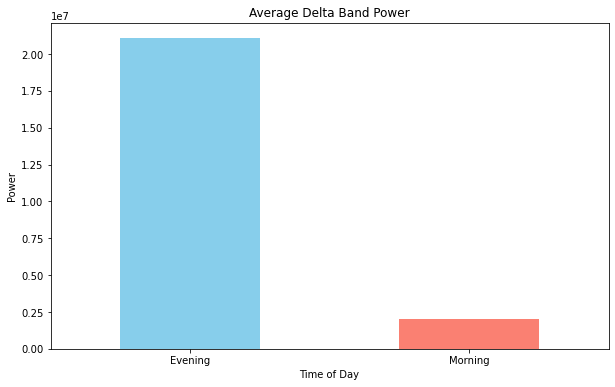

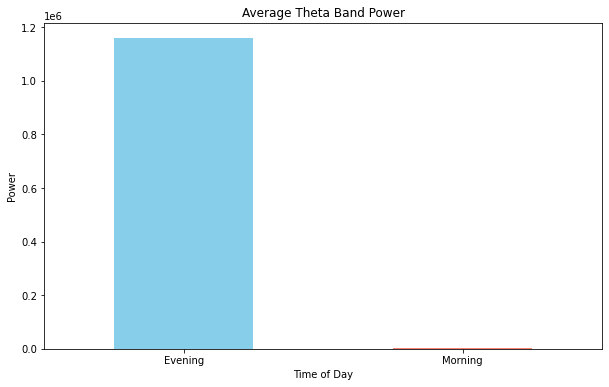

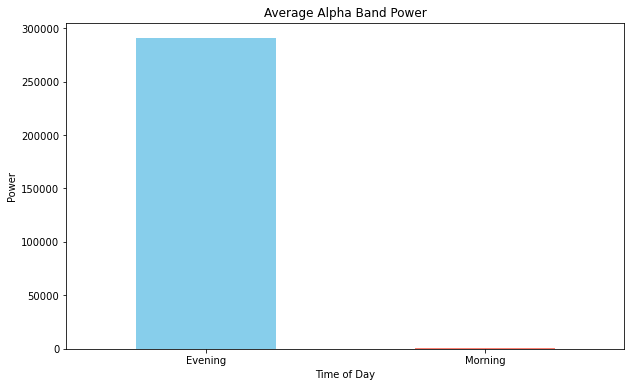

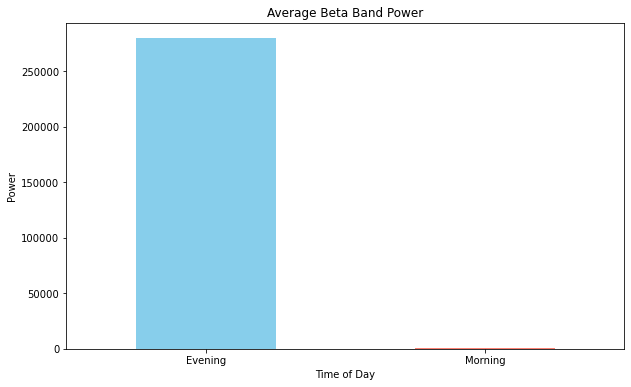

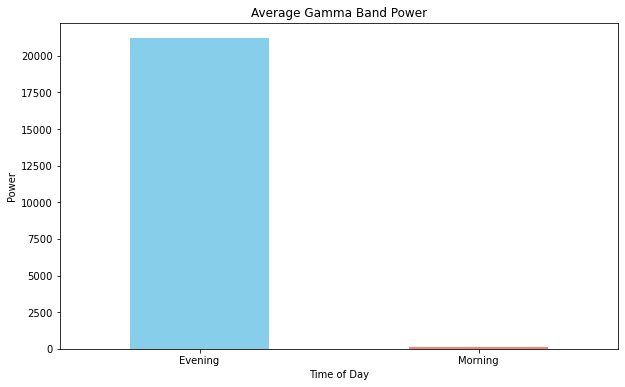

In [13]:
import matplotlib.pyplot as plt

# Function to plot bar charts
def plot_band_power_comparison(df, band):
    plt.figure(figsize=(10, 6))
    df.groupby('Time')[band].mean().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(f'Average {band.capitalize()} Band Power')
    plt.ylabel('Power')
    plt.xlabel('Time of Day')
    plt.xticks(rotation=0)
    plt.show()

# Plot for each band
for band in bands.keys():
    plot_band_power_comparison(features_df, band)



#### Prepare Data:

Convert the features dictionary into a DataFrame.
Add a column to distinguish between morning and evening data.

### Statistical Tests:

Use the t-test to compare the means of morning and evening power values for each band.
The ttest_ind function calculates the t-statistic and p-value, helping determine if there’s a significant difference.

#### Compare Data:

Calculate and display the average power for each frequency band in both morning and evening sessions.

#### Visualize Results:

Use bar charts to visualize the differences in average power between morning and evening sessions for each frequency band.
This analysis will provide you with statistical evidence of any significant differences between the morning and evening data and help you interpret these differences in the context of mental fatigue or stress.